# LSTM Time Series Model to Forecast Walmart sales

In [12]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import io
import warnings
warnings.filterwarnings('ignore')

In [6]:
# read csv data file
from google.colab import files
uploaded = files.upload()

Saving Walmart_Store_sales.csv to Walmart_Store_sales.csv


In [7]:
# Checking the first few rows and dimension of the dataset
df = pd.read_csv(io.BytesIO(uploaded['Walmart_Store_sales.csv']))
print('Shape of Data',df.shape)
df.head()

Shape of Data (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
# Format data
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

In [9]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...,...
3574,25,2012-10-26,688940.94,0,56.69,3.882,216.151590,7.293
714,5,2012-10-26,319550.77,0,71.70,3.506,224.037814,5.422
5719,40,2012-10-26,921264.52,0,49.65,3.917,138.728161,4.145
2573,18,2012-10-26,1127516.25,0,56.09,3.917,138.728161,8.243


In [13]:
# Use one store’s data
store_df1 = df[df['Store'] == 1]
sales = store_df1[['Weekly_Sales']].values

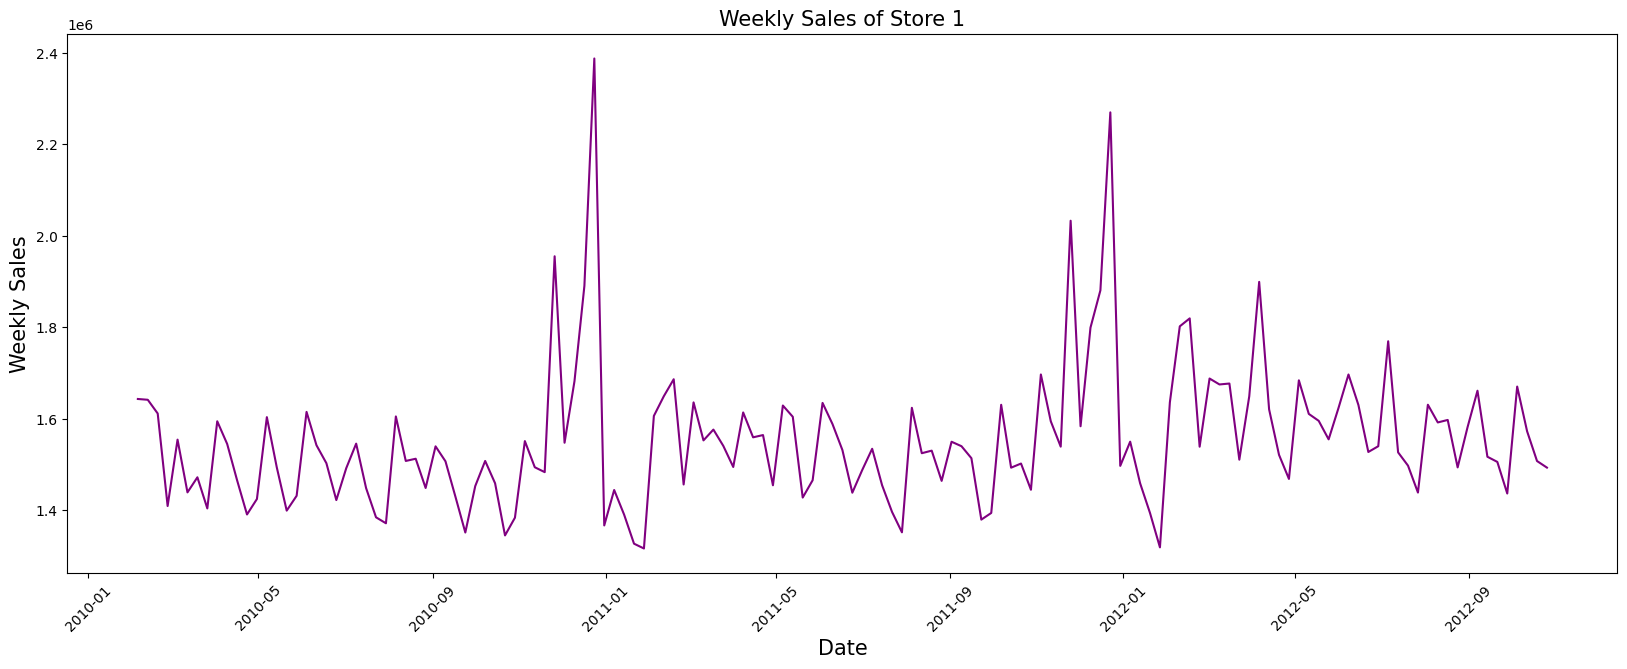

In [17]:
#Plot & Analyse sales
plt.figure(figsize=(20, 7))
sns.lineplot(x='Date', y='Weekly_Sales', data=store_df1,color ='purple')
plt.title('Weekly Sales of Store 1',fontsize = 15)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Weekly Sales',fontsize = 15)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Normalize
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

**Inference:**
    
We extract weekly sales and scale them to a 0-1 range. This normalization helps the LSTM converge faster and avoid bias due to scale differences.

# *Dataset Creation Using Sliding Window*

In [19]:
# Sequence generator
def create_dataset(df, step=4):
    X, Y = [], []
    for i in range(len(df)-step-1):
        X.append(df[i:(i+step), 0])
        Y.append(df[i+step, 0])
    return np.array(X), np.array(Y)

time_step = 4
X, y = create_dataset(sales_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

**Inference:**

We prepare the data for supervised learning by framing it as "given sales for the last step weeks, predict the next week." Reshaping is required for LSTM input of shape [samples, time steps, features].

In [20]:
#checking
X

array([[[0.30511304],
        [0.30349457],
        [0.27549472],
        [0.08667028]],

       [[0.30349457],
        [0.27549472],
        [0.08667028],
        [0.22212518]],

       [[0.27549472],
        [0.08667028],
        [0.22212518],
        [0.11450649]],

       [[0.08667028],
        [0.22212518],
        [0.11450649],
        [0.14529326]],

       [[0.22212518],
        [0.11450649],
        [0.14529326],
        [0.08172404]],

       [[0.11450649],
        [0.14529326],
        [0.08172404],
        [0.25962256]],

       [[0.14529326],
        [0.08172404],
        [0.25962256],
        [0.21335982]],

       [[0.08172404],
        [0.25962256],
        [0.21335982],
        [0.13926413]],

       [[0.25962256],
        [0.21335982],
        [0.13926413],
        [0.06942416]],

       [[0.21335982],
        [0.13926413],
        [0.06942416],
        [0.10102358]],

       [[0.13926413],
        [0.06942416],
        [0.10102358],
        [0.26801323]],

       [[0

In [21]:
# Train/Test/split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**Inference:**
    
Divide the dataset for the training and testing

# *Model Definition and Training*

In [25]:
# Build and train LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(time_step,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0540
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0405 
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307
Epoch 1

**Inference:**

The LSTM layer learns temporal dependencies. The Dense layer transforms LSTM outputs to a single sales prediction. Adam optimizer minimizes mean squared error (MSE) between predicted and true sales.

# *Prediction and Inverse Scaling*

In [30]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


**Inference:** 

We use the most recent sales sequence to predict the next week, then reverse scaling to restore actual dollar values.

# *Evaluation Metrics*

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Here y_true and y_pred are actual and predicted values (after inverse scaling)
y_true = y_test_inv
y_pred = test_pred

# Core Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Accuracy (for regression, as 100 - MAPE)
accuracy = 100 - mape

# Display Results
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.3f}")
print(f"Forecast Accuracy: {accuracy:.2f}%")


Root Mean Squared Error (RMSE): 84428.48
Mean Absolute Error (MAE): 71740.60
Mean Absolute Percentage Error (MAPE): 4.52%
R² Score: -0.123
Forecast Accuracy: 95.48%


**Inference:** 
>These metrics quantify model accuracy:

- RMSE gives average prediction error magnitude in dollars.

- MAE shows average absolute error.

- MAPE expresses error as a percentage, facilitating interpretability.

- R² indicates goodness of fit; closer to 1 is better.

Accuracy here is defined as 100% minus MAPE, a straightforward performance measure.



In [32]:
# Predict next week sales  using last sequence
last_seq = sales_scaled[-time_step:]
next_pred = model.predict(last_seq.reshape(1, time_step, 1))
next_sales = scaler.inverse_transform(next_pred)[0][0]
print(f"Next week predicted sales: ${next_sales:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Next week predicted sales: $1,551,222.38


# *Prepare dataset for Visualization of Forecasted Sale*

In [42]:
# Add next week's date (increment from last known date)
last_date = store_df1['Date'].iloc[-1]
next_week_date = last_date + pd.Timedelta(days=7)

In [43]:
# Append forecast point to data
forecast_df = store_df1[['Date', 'Weekly_Sales']].copy()
forecast_df = pd.concat([forecast_df,
    pd.DataFrame({'Date': [next_week_date], 'Weekly_Sales': [next_sales]})
], ignore_index=True)

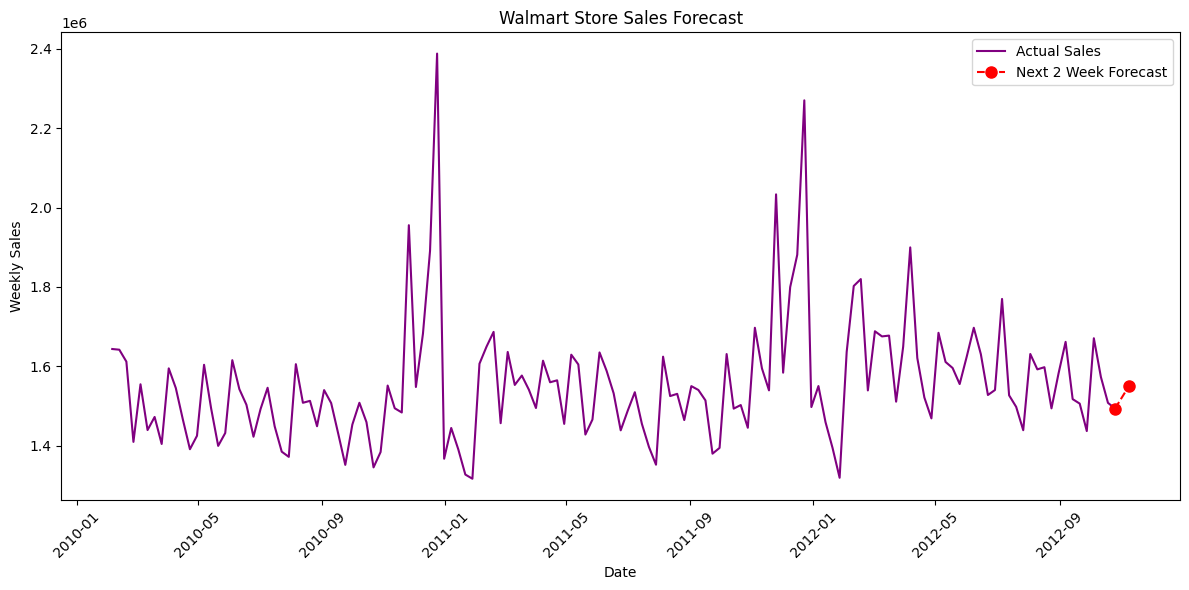

In [44]:
# Plot historical and forecasted sales
plt.figure(figsize=(12,6))
plt.plot(forecast_df['Date'][:-1], forecast_df['Weekly_Sales'][:-1], label='Actual Sales', color='purple')
plt.plot(forecast_df['Date'].iloc[-2:], forecast_df['Weekly_Sales'].iloc[-2:], 'r--o', label='Next Week Forecast', markersize=8)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Walmart Store Sales Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Inference:**
    
Plotting historical sales and next week's predicted sales helps visually assess the model’s forecast in context.

**Thank You**